In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill as pickle
from pathlib import Path
import os
from drccp_utils.plot_utils import NEURIPS_RCPARAMS, LINE_WIDTH

In [2]:
def load_data(exp_data):
    data_dir = Path(os.path.abspath('')).parent / "examples" / "data"
    data_dir.mkdir(parents=True, exist_ok=True)
    file_path = data_dir / exp_data
    with file_path.open('rb') as fid:
        data_cvar = pickle.load(fid)
    return data_cvar

def data_to_df(data_dict):
    df = pd.DataFrame(columns=['cvar', 'var', 'obj', 'n_sample', 'rkhs_radius'])
    cvar = data['cvar']
    obj = data['objective']
    var = data['var']
    for i, (rkhs_radius, results) in enumerate(cvar.items()):
        for n_sample in results:
            for j, res in enumerate(results[n_sample]):
                row = {'rkhs_radius': rkhs_radius,
                       'n_sample': n_sample,
                       'cvar': res,
                       'obj': obj[rkhs_radius][n_sample][j],
                       'var': var[rkhs_radius][n_sample][j],
                       'alpha': data['risk_level']}

                df = pd.concat([df, pd.Series(row).to_frame().T], ignore_index=True)
    return df

In [3]:
def plot(data, keys, name, data_dir):
    import seaborn as sns
    plt.rcParams.update(NEURIPS_RCPARAMS)
    sns.set_theme()
    marker = ['v', 'o', 's', 'd', 'p', '*', 'h']
    colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:purple']
    alpha = data['risk_level']

    plot_data = {}
    for key in keys:
        plot_data[key] = data[key]
    fig, ax = plt.subplots(1, len(keys), figsize=(LINE_WIDTH, LINE_WIDTH/2))
    if len(keys) == 1:
        ax = [ax]
    for j, (key, quantity) in enumerate(plot_data.items()):
        for i, (rkhs_radius, results) in enumerate(quantity.items()):
            n_samples = []
            res_val = []
            for n, res in results.items():
                if np.alltrue(np.isfinite(np.asarray(res).astype(np.double))):
                    res_val.append(res)
                    n_samples.append(n)
            if True:
                mean = [np.mean(rollouts) for rollouts in res_val]
                std = [np.std(rollouts)/np.sqrt(len(rollouts)) for rollouts in
                       res_val]
                if key == 'var':
                    mean = 1 - np.asarray(mean)
                if rkhs_radius == 'bootstrap':
                    label = r'$\mathcal{P}$ bootstrap'
                elif rkhs_radius == 'rate':
                    label = r'$\mathcal{P}$ rate'
                elif rkhs_radius == 0:
                    label = r'$\mathcal{P} = \{\hat{P}_n\}$'
                elif rkhs_radius == 'cv':
                    label = 'CV'
                else:
                    label = rf'$\varepsilon$ = {np.round(rkhs_radius, 5)}'
                ax[j].plot(n_samples, mean, label=label,
                           color=colors[i], marker=marker[i], ms=10)
                ax[j].fill_between(n_samples,
                                   np.subtract(mean, std),
                                   np.add(mean, std),
                                   alpha=0.2,
                                   color=colors[i])
                ax[j].set_xscale('log')

        ax[j].set_xlabel('sample size')
        if key == 'var':
            ax[j].set_ylabel(r'$P(f(x,\xi) > 0)$')
            ax[j].set_title(r'Constraint violation, $\alpha={}$'.format(alpha))
        elif key == 'objective':
            # ax[j].set_ylabel(r'$\max c^T x$')
            ax[j].set_ylabel(r'$c^Tx$')
            ax[j].set_title('Objective')
        elif key == 'cvar':
            ax[j].set_ylabel(r'$P_0-$CVaR')
            ax[j].set_title('Constraint')
        else:
            raise ValueError("The following key does not exist: ", key)

    plt.legend()
    plt.tight_layout()
    fig_name = "portfolio_{}.pdf".format(name)
    fig_path = data_dir / fig_name
    plt.savefig(fig_path, dpi=300)
    plt.show()

In [4]:
data = load_data('sos_cvar_data.pk')
df = data_to_df(data)

In [5]:
stats = df.groupby(['n_sample', 'rkhs_radius']).agg(
{
    'cvar': ['mean', 'std', 'sem'],
    'var': ['mean', 'std', 'sem'],
    'obj': ['mean', 'std', 'sem']
}
)
stats

cvar                           var            \
                          mean       std       sem      mean       std   
n_sample rkhs_radius                                                     
40       bootstrap    0.039749  0.025780  0.014884  0.929523  0.022635   
         rate         0.039427  0.026190  0.015121  0.929843  0.022963   
100      bootstrap    0.036600  0.009236  0.005332  0.930527  0.008385   
         rate         0.036586  0.009273  0.005354  0.930540  0.008416   
200      bootstrap    0.053897  0.011546  0.006666  0.919327  0.006583   
         rate         0.053885  0.011543  0.006665  0.919333  0.006579   

                                     obj                      
                           sem      mean       std       sem  
n_sample rkhs_radius                                          
40       bootstrap    0.013068  0.092181  0.008523  0.004921  
         rate         0.013257  0.092005  0.008454  0.004881  
100      bootstrap    0.004841  0.085781  0.002231  0.001288  
         rate         0.004859  0.085774  0.002227  0.001286  
200      bootstrap    0.003801  0.082405  0.002107  0.001217  
         rate         0.003798  0.082405  0.002107  0.001216

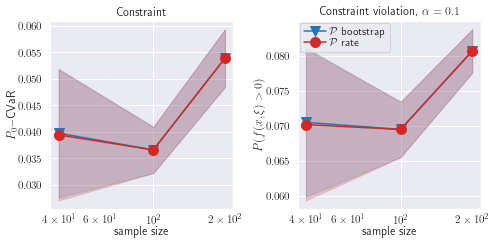

In [6]:
data_dir = Path(os.path.abspath('')).parent / "examples" / "data"
data_dir.mkdir(parents=True, exist_ok=True)
plot(data,['cvar', 'var'], 'sos_fig', data_dir)